# Reading the outputs with mortality

In [50]:
# Imports
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset

# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import seaborn as sns
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap

In [51]:
# Inputs

data_dir = '/home/abolmaal/modelling/FVCOM/Huron/output/mortality'
files = glob.glob(os.path.join(data_dir, "Fvcom_Huron_23_test_1.nc"))


# Open multiple NetCDF datasets with xarray, using chunks and parallel processing
datasets =  xr.open_mfdataset(files, combine='by_coords', chunks={'time': 10})

In [52]:
# outputs
fig_dir = '/home/abolmaal/modelling/FVCOM/Huron/figures'

In [53]:
# Select relevant variables: time, group_id, group_number, longitude, latitude
selected_vars = datasets[['time', 'group_id', 'age','is_alive' ,'longitude', 'latitude']]
# Stack across 'time' and 'particles', dropping unwanted dimensions
stacked_vars = selected_vars.stack(particle_time=('time', 'particles'))
# Convert longitudes greater than 180 to the range -180 to 180

# If longitude values are greater than 180, subtract 360 to convert them to the range -180 to 180
selected_vars['longitude'].values = np.where(selected_vars['longitude'].values > 180, 
                                             selected_vars['longitude'].values - 360, 
                                             selected_vars['longitude'].values)

In [54]:
# convert the stacked data to a pandas dataframe
PT_df = selected_vars.to_dataframe()

In [55]:
# Create a new dataframe and of in the dataframe if values of 'is_alive' is 1, keep the particle if is equal to 0 remove the particle 
PT_df_alive = PT_df[PT_df['is_alive'] == 1]
print(len(PT_df_alive))


945285


In [56]:
from shapely.geometry import Point
import geopandas as gpd

# Check that longitude and latitude are valid
PT_df_alive = PT_df_alive.dropna(subset=['longitude', 'latitude'])

# Create geometry from valid points
geometry = [Point(xy) for xy in zip(PT_df_alive['longitude'], PT_df_alive['latitude'])]

# Create GeoDataFrame
PT_df_alive = gpd.GeoDataFrame(PT_df_alive, geometry=geometry)

# Set CRS to EPSG:4326
PT_df_alive.set_crs('EPSG:4326', inplace=True)

# Convert CRS to EPSG:3174
PT_df_alive.to_crs('EPSG:3174', inplace=True)

In [57]:
# Assuming PT_df_alive is your GeoDataFrame with a MultiIndex
# Extract the 'time' level from the MultiIndex
PT_df_alive['time'] = PT_df_alive.index.get_level_values('time')

# Convert the 'time' column to datetime
PT_df_alive['time'] = pd.to_datetime(PT_df_alive['time'])

# Extract Julian day from the 'time' column
PT_df_alive['julian_day'] = PT_df_alive['time'].dt.dayofyear

# Display the updated GeoDataFrame with the new 'julian_day' column
print(PT_df_alive[['julian_day']].head())

                      julian_day
time       particles            
2023-05-01 0                 121
           1                 121
           2                 121
           3                 121
           4                 121


In [58]:
# Ensure that the data is grouped by Julian day and 'group_id' to count particles and compute the average age
alive_particles = PT_df_alive[PT_df_alive['is_alive'] == 1]

# Group by Julian day and group_id, and count the number of particles for each group at each Julian day
particle_count = alive_particles.groupby(['julian_day', 'group_id'])['group_id'].count().reset_index(name='particle_count')

# For the age, compute the average age for each group at each Julian day
average_age = alive_particles.groupby(['julian_day', 'group_id'])['age'].mean().reset_index(name='average_age')

# Merge the particle count and average age on Julian day and group_id
merged_data = pd.merge(particle_count, average_age, on=['julian_day', 'group_id'])

In [59]:
import seaborn as sns
# Filter the data for group_id == 0
group_0_data = PT_df_alive[PT_df_alive['group_id'] == 2]

# Ensure that the data is grouped by Julian day and 'group_id' to count the number of particles and compute the average age
alive_particles = group_0_data[group_0_data['is_alive'] == 1]

# Group by Julian day and group_id, and count the number of unique group_ids for each Julian day
particle_count = alive_particles.groupby(['julian_day', 'group_id'])['group_id'].count().reset_index(name='particle_count')

# For the age, compute the average age for each group at each Julian day
average_age = alive_particles.groupby(['julian_day', 'group_id'])['age'].mean().reset_index(name='average_age')

# Merge the particle count and average age on Julian day and group_id
merged_data = pd.merge(particle_count, average_age, on=['julian_day', 'group_id'])



/tmp/ipykernel_5256/4131083600.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(merged_data['julian_day'], merged_data['average_age'],  cmap='viridis', s=20)


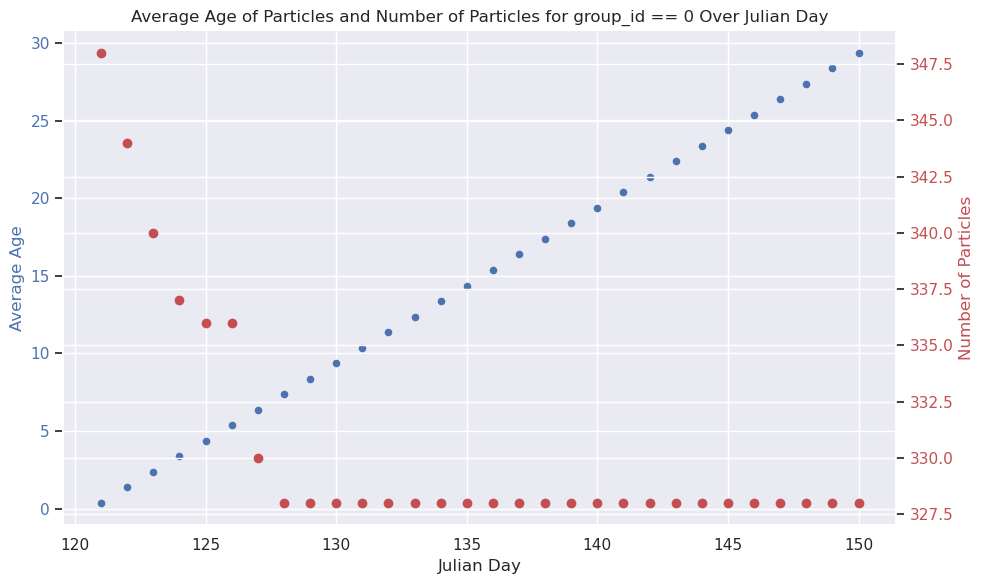

In [60]:
# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the average age (on the left axis)
ax1.scatter(merged_data['julian_day'], merged_data['average_age'],  cmap='viridis', s=20)
ax1.set_xlabel('Julian Day')
ax1.set_ylabel('Average Age', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for the number of particles (unique group ids)
ax2 = ax1.twinx()
ax2.scatter(merged_data['julian_day'], merged_data['particle_count'], color='r', label='Number of Particles')
ax2.set_ylabel('Number of Particles', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Show the plot
plt.title('Average Age of Particles and Number of Particles for group_id == 0 Over Julian Day')
fig.tight_layout()  # Adjust layout to avoid overlap
plt.show()

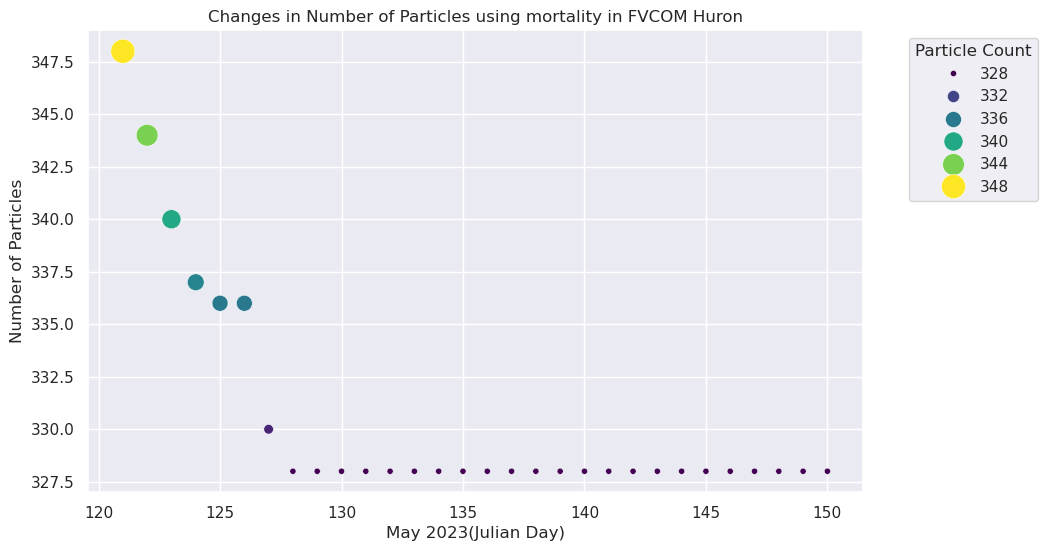

In [62]:
sns.set_theme(style="darkgrid")
sns.color_palette("Spectral", as_cmap=True)
# Create the scatter plot
plt.figure(figsize=(10, 6))

# Plot Julian day on the x-axis, particle count on the y-axis, and use the particle_count for size
sns.scatterplot(data=merged_data, x='julian_day', y='particle_count', 
                size='particle_count', sizes=(20, 300), hue='particle_count', palette='viridis', legend=True)

# Set labels and title
plt.xlabel('May 2023(Julian Day)')
plt.ylabel('Number of Particles')
plt.legend(title='Particle Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Changes in Number of Particles using mortality in FVCOM Huron')
plt.savefig(os.path.join(fig_dir, 'Change_numberofparticle_overtime.png'), dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


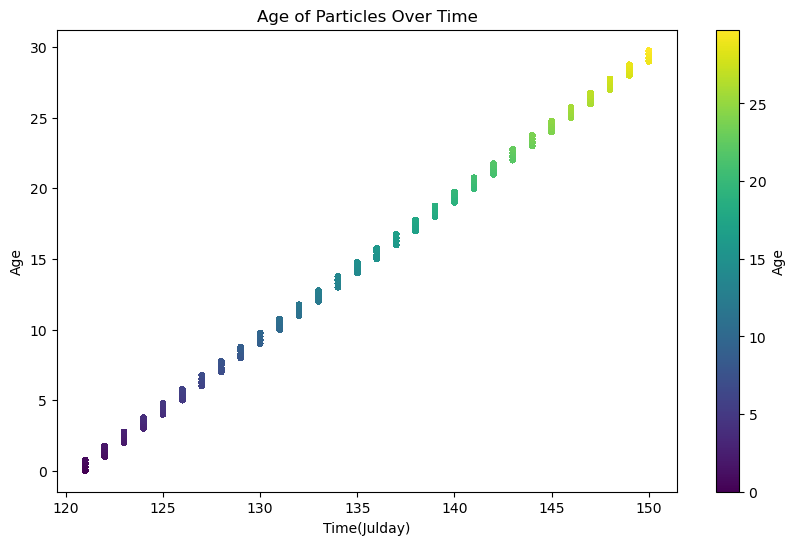

In [ ]:
# plot age versus time
# Create a new figure with a specified size
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the age of particles over time
# Scatter plot with color representing the age of particles
sc = ax.scatter(PT_df_alive['julian_day'], PT_df_alive['age'], c=PT_df_alive['age'], cmap='viridis', s=10)
# Set the title and labels
ax.set_title('Age of Particles Over Time')
ax.set_xlabel('May 2023(Julday)')
ax.set_ylabel('Age')
# Add a colorbar to indicate the age scale
cbar = plt.colorbar(sc)
cbar.set_label('Age')
# Show the plot
plt.show()